# Unit 3 Supervised Learning Capstone

This capstone project is fosused on prediction of the precense of heart disease in individuals using data obtained from traditional diagnostic tests. The data is provided by the Cleveland Clinic Database. The data was provided by [Kaggel](https://www.kaggle.com/) the HEART DISEASE webpage is at this link  [HD_Dataset](https://www.kaggle.com/ronitf/heart-disease-uci).

#### Data Overview
The original data set contained personal information and more features than is provide to the public. There were originally 76 attributes measured in the original data. The data has been scrubbed of personal identifiers and the attributes reduced to 14. Of the 14 attributes there are both catigorical and continous varibles. The target feature is binary to indicate either the precence or abcense of heart disease.

In [1]:
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pydotplus,graphviz, time, catboost, lightgbm, six, warnings, xgboost
import sklearn.datasets
import mlflow
from mlflow import sklearn as mlflow_sklearn
from collections import defaultdict
from IPython.display import Image
from scipy import sparse, stats
from sklearn import ensemble
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.externals.joblib import Parallel, delayed
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline, FeatureUnion, _fit_transform_one, _transform_one
RandomizedSearchCV

warnings.filterwarnings('ignore')
%matplotlib inline

## Import Data
### Data Set Exploration

In [2]:
# Read in data and look at the varibleas and thier data type
df = pd.read_csv('heart.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.2 KB


In [3]:
# Sample first three rows of the data set
df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


In [4]:
# General stats on data
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [5]:
# Look for missing data in the file 
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Feature ranking:
1. feature 2 (0.123461)
2. feature 11 (0.122243)
3. feature 12 (0.105652)
4. feature 8 (0.099064)
5. feature 9 (0.090297)
6. feature 7 (0.089412)
7. feature 0 (0.070276)
8. feature 10 (0.066147)
9. feature 3 (0.061347)
10. feature 4 (0.060417)
11. feature 1 (0.056156)
12. feature 6 (0.035791)
13. feature 5 (0.019738)


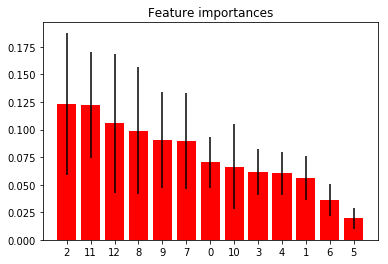

In [6]:
# Feature Importance 
X = df.drop('target', 1)
y = df['target']

forest = ExtraTreesClassifier(n_estimators=250, random_state=0)
                            
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")

plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [7]:
df_noninv = df.copy()

# Drop columns with catagorical data that is not pato 1545 null values named ctz
df_noninv = df_noninv.drop(['ca'], axis =1)

Feature ranking:
1. feature 2 (0.130858)
2. feature 11 (0.117547)
3. feature 8 (0.109886)
4. feature 7 (0.107800)
5. feature 9 (0.099985)
6. feature 0 (0.086285)
7. feature 10 (0.076955)
8. feature 3 (0.076360)
9. feature 4 (0.071911)
10. feature 1 (0.060019)
11. feature 6 (0.037318)
12. feature 5 (0.025075)


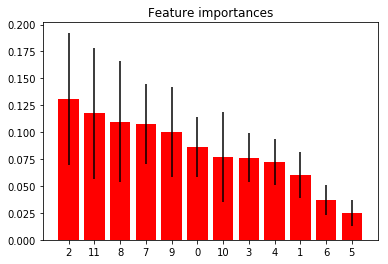

In [8]:
# Feature Importance 
X = df_noninv.drop('target', 1)
y = df_noninv['target']

forest = ExtraTreesClassifier(n_estimators=250, random_state=0)
                            
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")

plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

[0.70967742 0.58064516 0.70967742 0.83870968 0.74193548 0.63333333
 0.76666667 0.73333333 0.75862069 0.75862069]


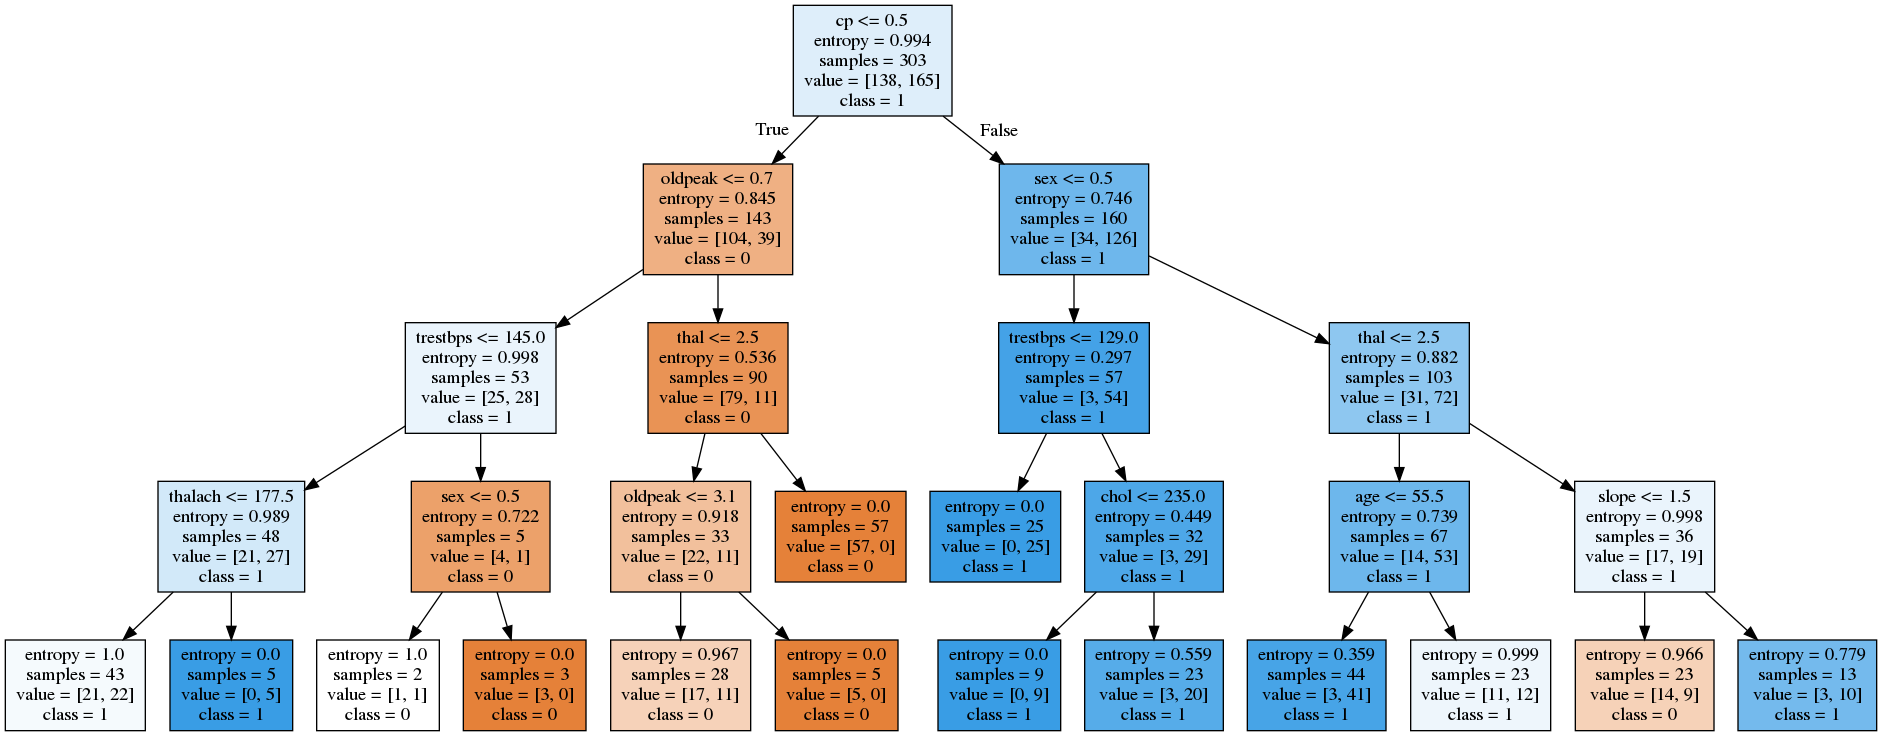

In [9]:
# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=3,
    max_depth=4
)

decision_tree.fit(X, y)

# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    class_names=['0','1','2','3','4','5','6','7','8','9','10', '11', '12'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
tree_plot = Image(graph.create_png())

#Create the model
rfc = ensemble.RandomForestClassifier()
score = cross_val_score(decision_tree, X, y, cv=10)
print(score)   
tree_plot

In [10]:
# Target Balance
print('Target Balance')
target_sum = df['target'].count()
target_count = df['target'].value_counts()
percent_pos = round(target_count[1] / target_sum *100,1)
percent_neg = 100 - percent_pos
print('Total number targets is {}, individuals with heart disease present is {}% positve and {}% negitive'.
      format(target_sum,str(percent_pos), str(percent_neg) ))


Target Balance
Total number targets is 303, individuals with heart disease present is 54.5% positve and 45.5% negitive


In [11]:
# Gender bias
print('Gender Bias')
gender_sum = df['sex'].count()
gender_count = df['sex'].value_counts()
percent_male = round(gender_count[1] / gender_sum *100,1)
percent_female = round(100 - percent_male,1)
print('Of the {} participents, {}% are Male and {}% are Female'.
      format(gender_sum,str(percent_male), str(percent_female) ))
print('')
print('Age Statistics Based on Gender')
age_female = df.age[df['sex']==0]
age_male = df.age[df['sex']==1]
df_age = df.copy()
df_age = df_age.groupby('sex')
(df_age['age'].describe())


Gender Bias
Of the 303 participents, 68.3% are Male and 31.7% are Female

Age Statistics Based on Gender


,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
0,96.0,55.677083,9.409396,34.0,49.75,57.0,63.0,76.0
1,207.0,53.758454,8.883803,29.0,47.00,54.0,59.5,77.0


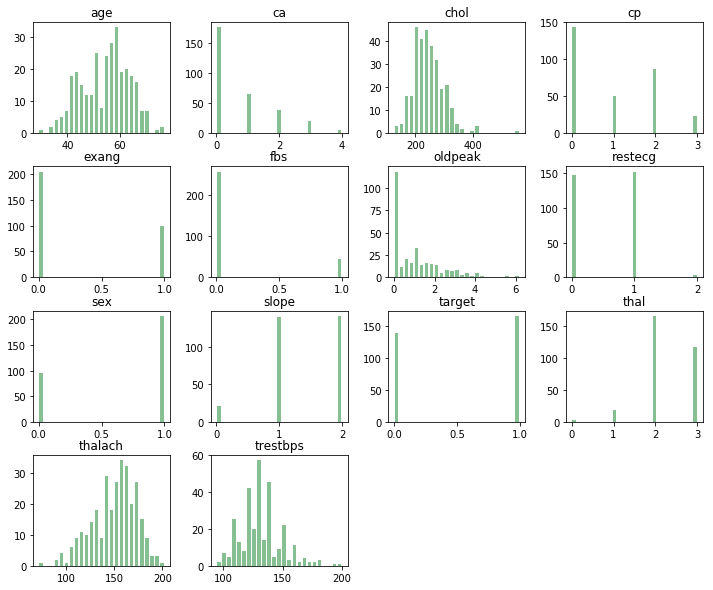

In [12]:
# Examine data for type, shape
df.hist(bins=25, grid=False, figsize=(12,10), color='#86bf91', zorder=2, rwidth=0.7)
plt.show()

In [13]:
# Create data sets based on Varible
gender_data = df.copy(deep=True)
gender_data.rename(columns={'sex':'Gender'}, inplace=True)

gender_data['Gender'][gender_data['Gender'] == 0] = 'Female'
gender_data['Gender'][gender_data['Gender'] == 1] = 'Male'

gender_data['target'][gender_data['target'] == 0] = 'Healthy Heart'
gender_data['target'][gender_data['target'] == 1] = 'Heart Disease'

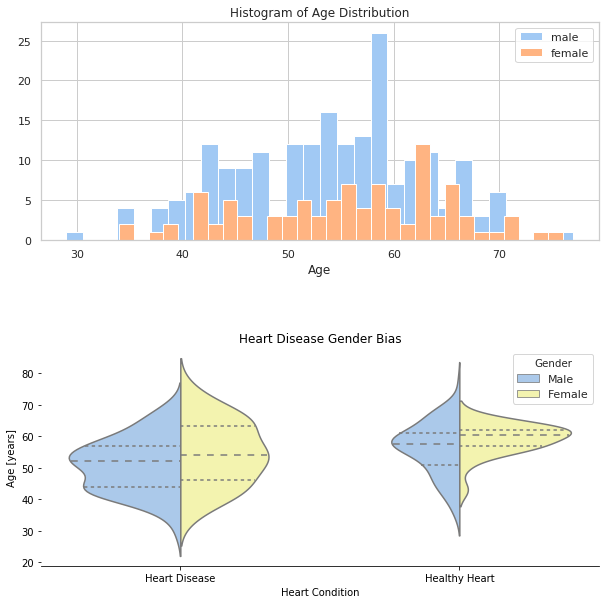

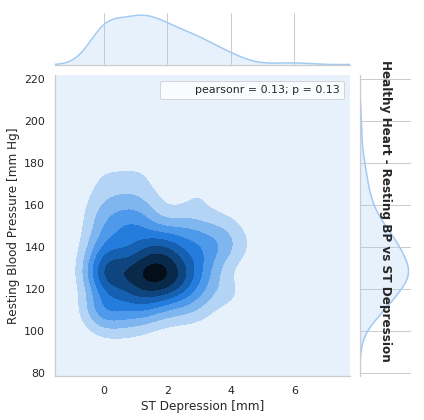

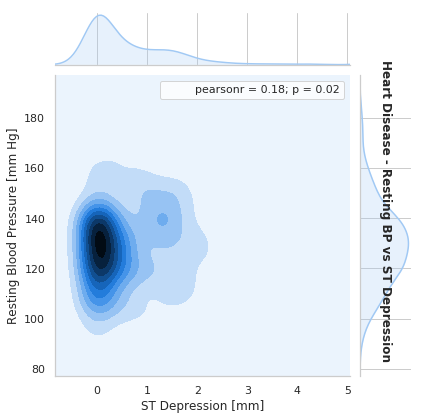

In [14]:
fig = plt.figure(2, figsize=(10,10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

plt.subplot(212)
sns.set(style="whitegrid", palette="pastel", color_codes=True)
ax = sns.violinplot(x="target", y="age", hue="Gender",
               split=True, inner="quart",
               palette={"Male": "b", "Female": "y"},
               data=gender_data)

ax.set_title('Heart Disease Gender Bias')
ax.set_ylabel('Age [years]')
ax.set_xlabel('Heart Condition')
sns.despine(left=True)

plt.subplot(211)
age_male.hist(bins=30)
age_female.hist(bins=30)
plt.title('Histogram of Age Distribution')
plt.legend(['male','female'])
plt.xlabel('Age')
plt.show()


ax = sns.jointplot(df["oldpeak"][df['target'] == 0], df["trestbps"][df['target'] == 0], kind='kde')
ax = ax.set_axis_labels('ST Depression [mm]', 'Resting Blood Pressure [mm Hg]')
plt.title('Healthy Heart - Resting BP vs ST Depression', fontweight='bold',  rotation =-90)
ax = ax.annotate(stats.pearsonr)

ax = sns.jointplot(df["oldpeak"][df['target'] == 1], df["trestbps"][df['target'] == 1], kind='kde')
ax = ax.set_axis_labels('ST Depression [mm]', 'Resting Blood Pressure [mm Hg]')
plt.title('Heart Disease - Resting BP vs ST Depression', fontweight='bold',  rotation =-90)
ax = ax.annotate(stats.pearsonr)


Text(0.5, 1.0, 'Age vs ST Depression')

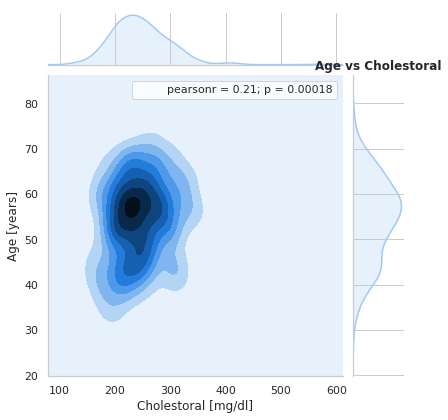

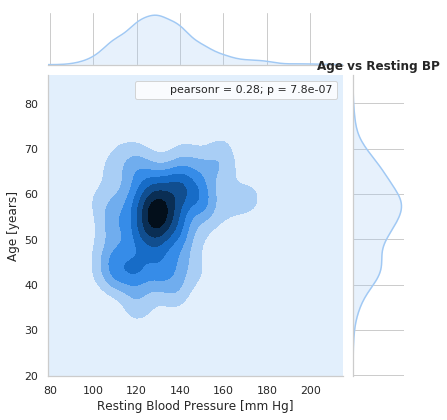

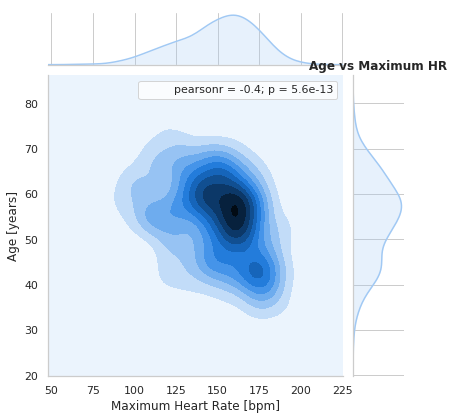

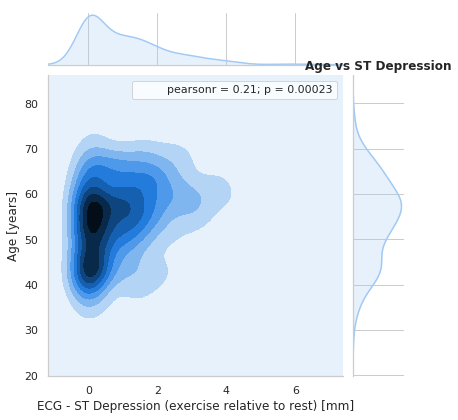

In [15]:

ax = sns.jointplot("chol", "age", data=gender_data, kind='kde')
ax = ax.annotate(stats.pearsonr)
ax = ax.set_axis_labels('Cholestoral [mg/dl]', 'Age [years]')
plt.title('Age vs Cholestoral', fontweight='bold')

ax = sns.jointplot("trestbps", "age", data=gender_data, kind='kde')
ax = ax.annotate(stats.pearsonr)
ax = ax.set_axis_labels('Resting Blood Pressure [mm Hg]', 'Age [years]')
plt.title('Age vs Resting BP', fontweight='bold')

ax = sns.jointplot("thalach", "age", data=gender_data, kind='kde')
ax = ax.annotate(stats.pearsonr)
ax = ax.set_axis_labels('Maximum Heart Rate [bpm]', 'Age [years]')
plt.title('Age vs Maximum HR', fontweight='bold')

ax = sns.jointplot("oldpeak", "age", data=gender_data, kind='kde')
ax = ax.annotate(stats.pearsonr)
ax = ax.set_axis_labels('ECG - ST Depression (exercise relative to rest) [mm]', 'Age [years]')
plt.title('Age vs ST Depression', fontweight='bold')

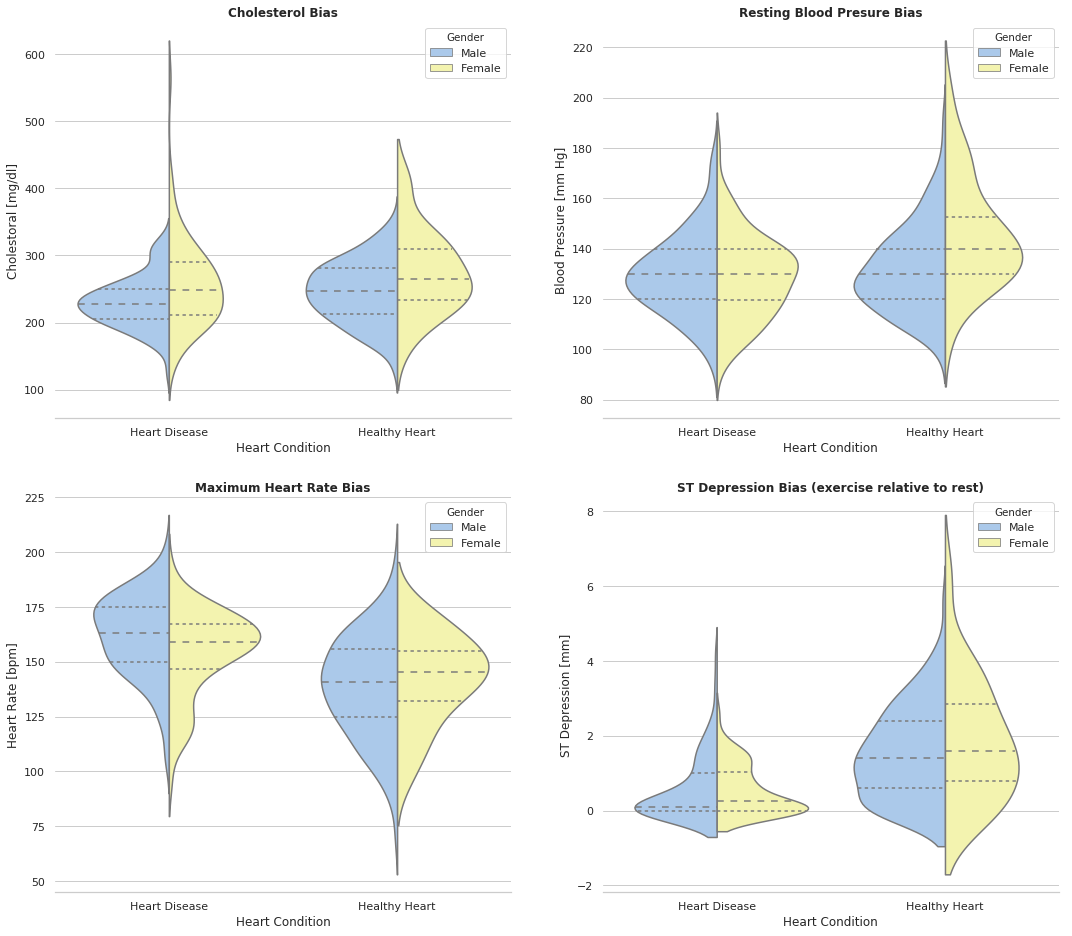

In [16]:

fig = plt.figure(1, figsize=(18,16))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

sns.set(style="whitegrid", palette="pastel", color_codes=True)
plt.subplot(221)
ax = sns.violinplot(x="target", y="chol", hue="Gender",
               split=True, inner="quart",
               palette={"Male": "b", "Female": "y"},
               data=gender_data)
ax.set_title('Cholesterol Bias', fontweight='bold')
ax.set_ylabel('Cholestoral [mg/dl]')
ax.set_xlabel('Heart Condition')
sns.despine(left=True)

plt.subplot(222)
ax = sns.violinplot(x="target", y="trestbps", hue="Gender",
               split=True, inner="quart",
               palette={"Male": "b", "Female": "y"},
               data=gender_data)
ax.set_title('Resting Blood Presure Bias', fontweight='bold')
ax.set_ylabel('Blood Pressure [mm Hg]')
ax.set_xlabel('Heart Condition')
sns.despine(left=True)

plt.subplot(223)
ax = sns.violinplot(x="target", y="thalach", hue="Gender",
               split=True, inner="quart",
               palette={"Male": "b", "Female": "y"},
               data=gender_data)
ax.set_title('Maximum Heart Rate Bias', fontweight='bold')
ax.set_ylabel('Heart Rate [bpm]')
ax.set_xlabel('Heart Condition')
sns.despine(left=True)

plt.subplot(224)
ax = sns.violinplot(x="target", y="oldpeak", hue="Gender",
               split=True, inner="quart",
               palette={"Male": "b", "Female": "y"},
               data=gender_data)
ax.set_title('ST Depression Bias (exercise relative to rest)', fontweight='bold' )
ax.set_ylabel('ST Depression [mm]')
ax.set_xlabel('Heart Condition')
sns.despine(left=True)
plt.show()

In [17]:

# Reorder columns to group varibles by type [continous, catagorical(ordinal), catagorical(binary)]
cols = list(df.columns.values)
new_index = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'cp',  'restecg', 'slope', 'ca', 'thal', 'exang', 'fbs', 'sex', 'target']
df = df.reindex(columns=new_index)
df.head(3)

,age,trestbps,chol,thalach,oldpeak,cp,restecg,slope,ca,thal,exang,fbs,sex,target
0,63,145,233,150,2.3,3,0,0,0,1,0,1,1,1
1,37,130,250,187,3.5,2,1,0,0,2,0,0,1,1
2,41,130,204,172,1.4,1,0,2,0,2,0,0,0,1


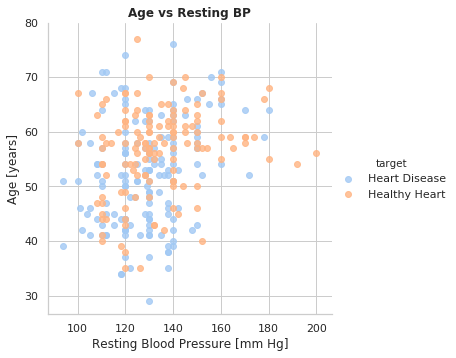

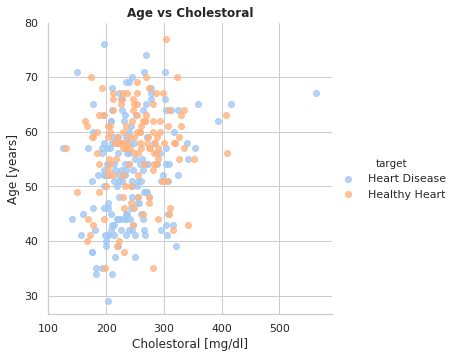

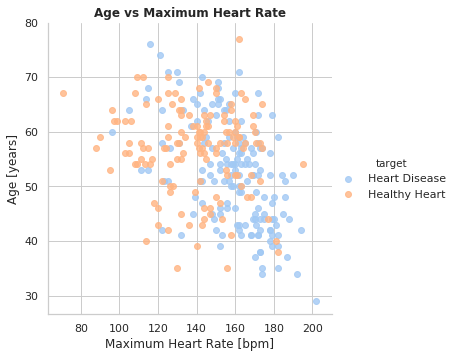

In [18]:

ax = sns.lmplot( x="trestbps", y="age", data=gender_data, fit_reg=False, hue='target', legend=True)
axes = ax.axes.flatten()
axes[0].set_title('Age vs Resting BP', fontweight='bold')
axes[0].set_ylabel('Age [years]')
for ax in axes:
    ax.set_xlabel('Resting Blood Pressure [mm Hg]')
plt.show()

ax = sns.lmplot( x="chol", y="age", data=gender_data, fit_reg=False, hue='target', legend=True)
axes = ax.axes.flatten()
axes[0].set_title('Age vs Cholestoral', fontweight='bold')
axes[0].set_ylabel('Age [years]')
for ax in axes:
    ax.set_xlabel('Cholestoral [mg/dl]')
plt.show()


ax = sns.lmplot( x="thalach", y="age", data=gender_data, fit_reg=False, hue='target', legend=True)
axes = ax.axes.flatten()
axes[0].set_title('Age vs Maximum Heart Rate', fontweight='bold')
axes[0].set_ylabel('Age [years]')
for ax in axes:
    ax.set_xlabel('Maximum Heart Rate [bpm]')
plt.show()


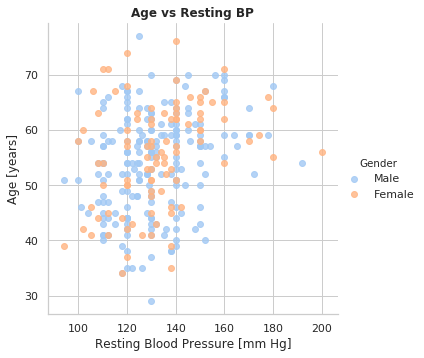

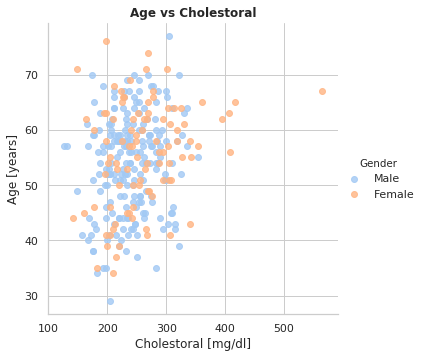

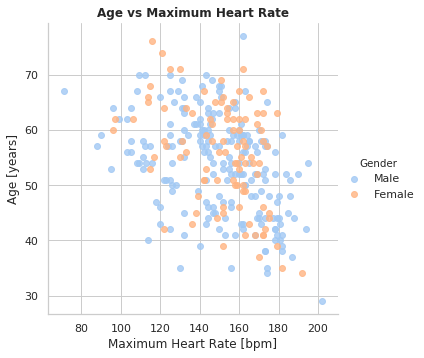

In [19]:

ax = sns.lmplot( x="trestbps", y="age", data=gender_data, fit_reg=False, hue='Gender', legend=True)
axes = ax.axes.flatten()
axes[0].set_title('Age vs Resting BP', fontweight='bold')
axes[0].set_ylabel('Age [years]')
for ax in axes:
    ax.set_xlabel('Resting Blood Pressure [mm Hg]')
plt.show()

ax = sns.lmplot( x="chol", y="age", data=gender_data, fit_reg=False, hue='Gender', legend=True)
axes = ax.axes.flatten()
axes[0].set_title('Age vs Cholestoral', fontweight='bold')
axes[0].set_ylabel('Age [years]')
for ax in axes:
    ax.set_xlabel('Cholestoral [mg/dl]')
plt.show()


ax = sns.lmplot( x="thalach", y="age", data=gender_data, fit_reg=False, hue='Gender', legend=True)
axes = ax.axes.flatten()
axes[0].set_title('Age vs Maximum Heart Rate', fontweight='bold')
axes[0].set_ylabel('Age [years]')
for ax in axes:
    ax.set_xlabel('Maximum Heart Rate [bpm]')
plt.show()


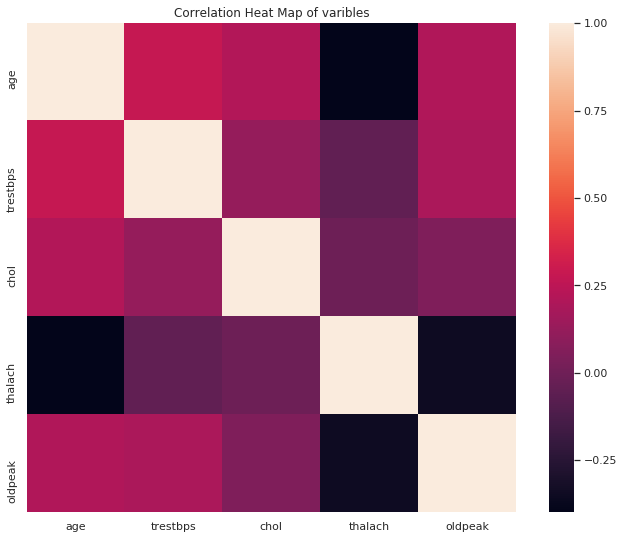

In [20]:
# Inspect correlations of continous 

#df_corr = df.drop(['target'], axis =1)
df_corr = df.loc[:, :'oldpeak']
corrmat = df_corr.corr()

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1, square=True)
plt.title('Correlation Heat Map of varibles')
plt.show()

In [21]:
class PandasFeatureUnion(FeatureUnion):
    def fit_transform(self, X, y=None, **fit_params):
        self._validate_transformers()
        result = Parallel(n_jobs=self.n_jobs)(
            delayed(_fit_transform_one)(trans, X, y, weight,
                                        **fit_params)
            for name, trans, weight in self._iter())

        if not result:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        Xs, transformers = zip(*result)
        self._update_transformer_list(transformers)
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

    def merge_dataframes_by_column(self, Xs):
        return pd.concat(Xs, axis="columns", copy=False)

    def transform(self, X):
        Xs = Parallel(n_jobs=self.n_jobs)(
            delayed(_transform_one)(trans, X, None, weight)
            for name, trans, weight in self._iter())
        if not Xs:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

In [22]:
def _name_estimators(estimators):
    """Generate names for estimators."""

    names = [type(estimator).__name__.lower() for estimator in estimators]
    namecount = defaultdict(int)
    for est, name in zip(estimators, names):
        namecount[name] += 1

    for k, v in list(six.iteritems(namecount)):
        if v == 1:
            del namecount[k]

    for i in reversed(range(len(estimators))):
        name = names[i]
        if name in namecount:
            names[i] += "-%d" % namecount[name]
            namecount[name] -= 1

    return list(zip(names, estimators))

In [23]:
def make_pandas_union(*transformers, **kwargs):
    n_jobs = kwargs.pop('n_jobs', None)
    if kwargs:
        raise TypeError('Unknown keyword arguments: "{}"'
                        .format(list(kwargs.keys())[0]))
    return PandasFeatureUnion(_name_estimators(transformers), n_jobs=n_jobs)

In [24]:
class OrdinalEncoderPandas(TransformerMixin, BaseEstimator):
    def __init__(self, columns):
        self.columns = columns
        self.transformers = {}
    
    def fit(self, X, y=None):
        for column in self.columns:
            self.transformers[column] = ce.OrdinalEncoder(return_df=False, handle_unknown="impute").fit(X[[column]])
        return self
    
    def transform(self, X, y=None):
        X = X.drop(list(set(X.columns) - set(self.columns)), axis=1)
        for column in self.columns:
            X[column] = self.transformers[column].transform(X[[column]])
            X[column] = X[column].apply(lambda x: x if x else -1)
        return X

In [25]:
class OneHotEncoderPandas(TransformerMixin, BaseEstimator):
    def __init__(self, columns):
        self.columns = columns
        self.transformers = {}
        self.feature_names = {}
        self.feature_names_all = []

    def fit(self, X, y=None):
        for column in self.columns:
            self.transformers[column] = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(X[[column]])
            features = [f"{column}_{i}" for i in self.transformers[column].get_feature_names()]
            self.feature_names[column] = features
            for feature in features:
                self.feature_names_all.append(feature)
        return self

    def transform(self, X, y=None):
        ohe_df_list = []
        for column in self.columns:
            ohe_df = pd.DataFrame(self.transformers[column].transform(X[[column]]))
            feature_names = [f"{column}_{i}" for i in self.transformers[column].get_feature_names()]
            ohe_df.columns = self.feature_names[column]
            ohe_df_list.append(ohe_df)
        ohe_df_concat = pd.concat(ohe_df_list, axis=1)
        return ohe_df_concat

In [26]:
class DropColumn(TransformerMixin, BaseEstimator):
    def __init__(self, columns, no_drops):
        self.columns = columns
        self.no_drops = no_drops

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        for column in self.columns:
            if column in X.columns:
                drop_together = False
                if self.no_drops:
                    for no_drop in self.no_drops:
                        if column == no_drop and self.no_drops[no_drop] not in X.columns:
                            drop_together = True
                if not drop_together:
                    X = X.drop(columns=column)
            else:
                print(f"Drop Warning: Column {column} not in X")
        return X

In [27]:
class ChangeColumnType(TransformerMixin, BaseEstimator):
    def __init__(self, types):
        self.types = types

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        for column in self.types.keys():
            if column in X.columns:
                X[column] = X[column].astype(self.types[column])
            else:
                print(f"Change Warning: Column {column} not in X")
        return X

## Notes:
- XGBoost/Random Forest requires OHE of categorical variables unless categorial variable is ordinal
- XGBoost/LightGBM/Catboost supports missing variables, but RandomForests do not (most models in sklearn does not support missing values)

### Features 5 to 9 (4 feature in total) categorical type (non-binary)

In [28]:
df_samples = df_noninv.copy()

In [29]:
categorical_features = list(df_samples.columns[5:9])
target = "target"

In [30]:
# for i in categorical_features:
#     df_samples[i] = abs(df_samples[i]).astype(int).astype(str)

In [31]:
df_samples.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,2,1


### Pipeline for Models that does not support categorical variables

Need to use OHE, only when you know the data is not ordinal, otherwise you can use ordinal encoding

XGBoost, RandomForest (CART can handle categorical, but RF does not have this implemented)

In [32]:
pipe_ohe = make_pipeline(
    make_pandas_union(
        DropColumn(columns=categorical_features, no_drops=None),
        make_pipeline(
            ChangeColumnType(types={i: str for i in categorical_features}),
            OneHotEncoderPandas(columns=categorical_features)
        )
    )
)

In [33]:
pipe_ohe.fit_transform(df_samples).head(5)

,age,sex,cp,trestbps,chol,oldpeak,slope,thal,target,fbs_x0_0,...,thalach_x0_202,thalach_x0_71,thalach_x0_88,thalach_x0_90,thalach_x0_95,thalach_x0_96,thalach_x0_97,thalach_x0_99,exang_x0_0,exang_x0_1
0,63,1,3,145,233,2.3,0,1,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,37,1,2,130,250,3.5,0,2,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,41,0,1,130,204,1.4,2,2,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,56,1,1,120,236,0.8,2,2,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,57,0,0,120,354,0.6,2,2,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [34]:
ohe_columns = list(set(pipe_ohe.fit_transform(df_samples).columns) - set([target]))

### Pipeline for models that support categorical variables

LightGBM, CatBoost can handle categorical variables

In [35]:
pipe_cat = make_pipeline(
    make_pandas_union(
        DropColumn(columns=categorical_features, no_drops=None),
        OrdinalEncoderPandas(columns=categorical_features)
    ),
    ChangeColumnType(types={i: "category" for i in categorical_features}),
)

In [36]:
pipe_cat.fit_transform(df_samples).head(5)

,age,sex,cp,trestbps,chol,oldpeak,slope,thal,target,fbs,restecg,thalach,exang
0,63,1,3,145,233,2.3,0,1,1,1,1,1,1
1,37,1,2,130,250,3.5,0,2,1,2,2,2,1
2,41,0,1,130,204,1.4,2,2,1,2,1,3,1
3,56,1,1,120,236,0.8,2,2,1,2,2,4,1
4,57,0,0,120,354,0.6,2,2,1,2,2,5,2


## Training/Testing/Validation

In [37]:
df_samples_ohe = pipe_ohe.fit_transform(df_samples)
train_ohe, test_ohe = train_test_split(df_samples_ohe, test_size=0.2, stratify=df_samples_ohe[target], random_state=0)
train_ohe, valid_ohe = train_test_split(train_ohe, test_size=0.2, stratify=train_ohe[target], random_state=0)

In [38]:
df_samples_cat = pipe_cat.fit_transform(df_samples)
train_cat, test_cat = train_test_split(df_samples_cat, test_size=0.2, stratify=df_samples_cat[target], random_state=0)
train_cat, valid_cat = train_test_split(train_cat, test_size=0.2, stratify=train_cat[target], random_state=0)

### Without ML-Flow

In [139]:
rf_classifier = RandomForestClassifier(
    criterion='entropy',
    max_features=None,
    n_estimators=53,
    max_depth=3,
    random_state=0,
    n_jobs=10)

In [140]:
rf_classifier.fit(X=train_ohe[ohe_columns], y=train_ohe[target])
# Use validation set to modify hyperparameters
print(accuracy_score(valid_ohe[target], rf_classifier.predict(valid_ohe[ohe_columns])))
# Use testing set to evaluate final performance
print(accuracy_score(test_ohe[target], rf_classifier.predict(test_ohe[ohe_columns])))

0.7755102040816326
0.7868852459016393


In [97]:
xgb_classifier = xgboost.XGBClassifier(
    max_depth=4,
    learning_rate=0.19,
     random_state=0,
    n_estimators=24
)

In [98]:
xgb_classifier.fit(X=train_ohe[ohe_columns], y=train_ohe[target])
# Use validation set to modify hyperparameters
print(accuracy_score(valid_ohe[target], xgb_classifier.predict(valid_ohe[ohe_columns])))
# Use testing set to evaluate final performance
print(accuracy_score(test_ohe[target], xgb_classifier.predict(test_ohe[ohe_columns])))

0.7959183673469388
0.7868852459016393


In [209]:
lgb_classifier = lightgbm.LGBMClassifier(
    objective="binary",
    categorical_features="auto",
    max_depth=3,
    learning_rate=0.09,
     random_state=0,
    n_estimators=27)

In [210]:
lgb_classifier.fit(X=train_ohe[ohe_columns], y=train_ohe[target])
# Use validation set to modify hyperparameters
print(accuracy_score(valid_ohe[target], lgb_classifier.predict(valid_ohe[ohe_columns])))
# Use testing set to evaluate final performance
print(accuracy_score(test_ohe[target], lgb_classifier.predict(test_ohe[ohe_columns])))

0.7959183673469388
0.819672131147541


In [288]:
cat_classifier = catboost.CatBoostClassifier(
    max_depth=3,
    learning_rate=0.1,
    n_estimators=23,
    random_state=0,
    verbose=0
)

In [289]:
cat_classifier.fit(X=train_ohe[ohe_columns], y=train_ohe[target])
# Use validation set to modify hyperparameters
print(accuracy_score(valid_ohe[target], cat_classifier.predict(valid_ohe[ohe_columns])))
# Use testing set to evaluate final performance
print(accuracy_score(test_ohe[target], cat_classifier.predict(test_ohe[ohe_columns])))

0.8163265306122449
0.8032786885245902


## With ML-Flow

In [ ]:
mlflow.set_experiment("Training/Testing/Validation")

In [ ]:
with mlflow.start_run(run_name="Random Forest"):
    criterion = "entropy"
    max_features = None
    n_estimators = 20
    max_depth = 4
    
    rf_classifier = RandomForestClassifier(
        criterion=criterion,
        max_features=max_features,
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=0,
        n_jobs=4)
    rf_classifier.fit(X=train_ohe[ohe_columns], y=train_ohe[target])
    
    valid_accuracy = accuracy_score(valid_ohe[target], rf_classifier.predict(valid_ohe[ohe_columns]))
    test_accuracy = accuracy_score(test_ohe[target], rf_classifier.predict(test_ohe[ohe_columns]))
    
    mlflow.log_param("criterion", criterion)
    mlflow.log_param("max_features", max_features)
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)
    
    mlflow.log_metric("valid_accuracy", valid_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)

    mlflow_sklearn.log_model(rf_classifier, "model")

In [ ]:
with mlflow.start_run(run_name="XGBoost"):
    n_estimators = 200
    max_depth = 4
    learning_rate = 0.008
    
    xgb_classifier = xgboost.XGBClassifier(
        max_depth=max_depth,
        random_state=0,
        learning_rate=learning_rate,
        n_estimators=n_estimators
    )
    xgb_classifier.fit(X=train_ohe[ohe_columns], y=train_ohe[target])
    
    valid_accuracy = accuracy_score(valid_ohe[target], xgb_classifier.predict(valid_ohe[ohe_columns]))
    test_accuracy = accuracy_score(test_ohe[target], xgb_classifier.predict(test_ohe[ohe_columns]))
    
    mlflow.log_param("criterion", criterion)
    mlflow.log_param("max_features", max_features)
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)
    
    mlflow.log_metric("valid_accuracy", valid_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)

    mlflow_sklearn.log_model(xgb_classifier, "model")

In [ ]:
with mlflow.start_run(run_name="LightGBM"):
    objective = "binary"
    categorical_features = "auto"
    n_estimators = 200
    max_depth = 4
    learning_rate = 0.01
    
    lgb_classifier = lightgbm.LGBMClassifier(
        objective=objective,
        categorical_features=categorical_features,
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators
    )
    lgb_classifier.fit(X=train_ohe[ohe_columns], y=train_ohe[target])
    
    valid_accuracy = accuracy_score(valid_ohe[target], lgb_classifier.predict(valid_ohe[ohe_columns]))
    test_accuracy = accuracy_score(test_ohe[target], lgb_classifier.predict(test_ohe[ohe_columns]))
    
    mlflow.log_param("criterion", criterion)
    mlflow.log_param("max_features", max_features)
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)
    
    mlflow.log_metric("valid_accuracy", valid_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)

    mlflow_sklearn.log_model(lgb_classifier, "model")

In [ ]:
with mlflow.start_run(run_name="CatBoost"):
    n_estimators = 200
    max_depth = 8
    learning_rate = 0.01
    
    cat_classifier = catboost.CatBoostClassifier(
        max_depth=max_depth,
        learning_rate=learning_rate,
        random_state=0,
        n_estimators=n_estimators,
        verbose=0
    )
    cat_classifier.fit(X=train_ohe[ohe_columns], y=train_ohe[target])
    
    valid_accuracy = accuracy_score(valid_ohe[target], cat_classifier.predict(valid_ohe[ohe_columns]))
    test_accuracy = accuracy_score(test_ohe[target], cat_classifier.predict(test_ohe[ohe_columns]))
    
    mlflow.log_param("criterion", criterion)
    mlflow.log_param("max_features", max_features)
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)
    
    mlflow.log_metric("valid_accuracy", valid_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)

    mlflow_sklearn.log_model(cat_classifier, "model")

In [ ]:
!mlflow ui --host 0.0.0.0

### Using Gridsearch

#### Random Forest


In [ ]:
rf_random_search = RandomizedSearchCV(
    RandomForestClassifier(
        criterion='entropy',
        max_features=None,
        random_state=0
    ),
    param_distributions={
        "max_depth": [i+1 for i in range(5)],
        "n_estimators": [i+5 for i in range(200)]
    },
    n_iter=10,
    random_state=0,
    n_jobs=-1,
    cv=5,
    verbose=5
)
rf_random_search.fit(X=train_ohe[ohe_columns], y=train_ohe[target])

In [ ]:
# Use validation set to modify hyperparameters
print(accuracy_score(valid_ohe[target], rf_random_search.predict(valid_ohe[ohe_columns])))
# Use testing set to evaluate final performance
print(accuracy_score(test_ohe[target], rf_random_search.predict(test_ohe[ohe_columns])))

In [ ]:
rf_grid_search = GridSearchCV(
    RandomForestClassifier(
        criterion='entropy',
        max_features=None,
        random_state=0
    ),
    param_grid={
        "max_depth": [i+1 for i in range(2)],
        "n_estimators": [i+200 for i in range(2)]
    },
    n_jobs=-1,
    cv=5,
    verbose=5
)
rf_grid_search.fit(X=train_ohe[ohe_columns],y=train_ohe[target])

In [ ]:
# Use validation set to modify hyperparameters
print(accuracy_score(valid_ohe[target], rf_grid_search.predict(valid_ohe[ohe_columns])))
# Use testing set to evaluate final performance
print(accuracy_score(test_ohe[target], rf_grid_search.predict(test_ohe[ohe_columns])))

### XGBoost

In [ ]:
xgb_random_search = RandomizedSearchCV(
    xgboost.XGBClassifier(
        nthread=1
    ),
    param_distributions={
        "learning_rate": [0.05, 0.01, 0.008, 0.005, 0.001],
        "max_depth": [i+1 for i in range(5)],
        "n_estimators": [i+5 for i in range(200)]
    },
    n_iter=10,
    random_state=0,
    n_jobs=10,
    cv=5,
    verbose=5
)
xgb_random_search.fit(X=train_ohe[ohe_columns],y=train_ohe[target])

In [ ]:
# Use validation set to modify hyperparameters
print(accuracy_score(valid_ohe[target], xgb_random_search.predict(valid_ohe[ohe_columns])))
# Use testing set to evaluate final performance
print(accuracy_score(test_ohe[target], xgb_random_search.predict(test_ohe[ohe_columns])))

In [ ]:
xgb_grid_search = GridSearchCV(
    xgboost.XGBClassifier(
        learning_rate=0.065,
        random_state=0,
        nthread=1
    ),
    param_grid={
        "max_depth": [i+1 for i in range(2)],
        "n_estimators": [i+200 for i in range(2)]
    },
    n_jobs=10,
    cv=5,
    verbose=5
    
)
xgb_grid_search.fit(X=train_ohe[ohe_columns],y=train_ohe[target])

In [ ]:
# Use validation set to modify hyperparameters
print(accuracy_score(valid_ohe[target], xgb_grid_search.predict(valid_ohe[ohe_columns])))
# Use testing set to evaluate final performance
print(accuracy_score(test_ohe[target], xgb_grid_search.predict(test_ohe[ohe_columns])))

In [ ]:
cat_grid_search = GridSearchCV(

    catboost.CatBoostClassifier(
        learning_rate=0.01,
        random_state=0,      

    ),
     param_grid={
        "max_depth": [i+1 for i in range(2)],
        "n_estimators": [i+200 for i in range(2)]
    },
    n_jobs=10,
    cv=5,
    verbose=5
    
)
cat_grid_search.fit(X=train_ohe[ohe_columns],y=train_ohe[target])

In [ ]:
# Use validation set to modify hyperparameters
print(accuracy_score(valid_ohe[target], cat_grid_search.predict(valid_ohe[ohe_columns])))
# Use testing set to evaluate final performance
print(accuracy_score(test_ohe[target], cat_grid_search.predict(test_ohe[ohe_columns])))

### Variable descriptions and explanations

  1. age - subject's age in years

  2. sex - subject's gender (1 = Male, 0 = female)

  3. cp - chest pain type 4 values, (0 = typical angina, 1 = atypical angina, 2 = non-anginal pain, 3 = asymptomatic)

      * Typical angina is a common condition caused from ischemia or the lack of blood or oxygen to the heart muscle, most common in men. The symptoms are reported as tightness or pain felt in the chest after physical activities or stress.

      * Atypical angina is more common in women and is a more subtle with reported symptoms of fatigue, sleep disturbances, shortness of breath and may be accompanied with chest discomfort.

      * Non-anginal pain is caused by other conditions and can easily be mistaken for angina in emergency situations where the patient’s well-being can take precedence over time consuming evaluations.

      * Asymptomatic chest pain is the lack of the patient felling pain or tightness in their chest, yet other tests indicate there is the presence of myocardial infarction, "the silent heart attack"

  4. trestbps - resting blood pressure in mm Hg, measured on admission to the hospital 

  5. chol - serum cholesterol measured in mg/dl 

  6. fbs - fasting blood sugar > 120 mg/dl, (1 = True, 0 = False)

  7. restecg - resting electrocardiographic results (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite LVH (left ventricular hypertrophy) by Estes' criteria)

      * Normal ecg and chest pain are typical symptoms of anxiety (panic attack).

      * ST-T wave abnormality is commonly linked to myocardial (Heart Muscle) disease.

      * LVH (Left Ventricular Hypertrophy) by Estes' criteria is an indication that the patient suffers from heart valve disease and may or may not have myocardial disease.

  8. thalach - maximum heart rate achieved during an exercise protocol, measured in bpm (beats per minute)

  9. exang - exercise induced angina (1 = True, 0 = False)

  10. oldpeak - ST depression induced by exercise relative to rest, measured in mm

      * ECG (electrocardiogram) originally was recorded on a paper chart where one square = to 1mm.

      * ST segment depression may occur as a normal variant

      * ST segment depression is a diagnostic tool to determine the presence of obstructive coronary atherosclerosis.

  11. slope - the slope of the peak exercise ST segment (0 = upsloping, 1 = flat, 2 = down sloping)

      * normal slope is upwards

      * abnormal slope is flat or downward

      * false positives are common in women

  12. ca - number of major vessels (0-3) colored by fluoroscopy during an angiogram. Values of 0 to 4 indicating the number of vessels seen with blood flow going through them.

      * Values of **zero** would question if the procedure was performed as no flow through the arteries is not realistic.

      * An angiogram is an invasive procedure where a contrast dye in introduced by a catheter so the coronary arteries can be imaged using x-rays.

      * The procedure is diagnostic and a surgery aid to place stents, perform angioplasty and for cardiac catheterization.

      * Normal is where all 4 major coronary vessels can be seen

  13. thal - Thallium stress test, where the contrast agent thallium is introduced to provide imaging by a gamma camera in order to image the perfusion of blood and oxygen throughout the heart muscle.  

      * Original dataset values given (3 = normal; 6 = fixed defect; 7 = reversible defect) do not match the data set values 0-3.

      * Assuming that a value of zero would mean the procedure was not performed, we will assign 1-3 with the assumption that 1 = normal, 2 = fixed defect, 3 = reversible defect.

      

